# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Generating-Data" data-toc-modified-id="Generating-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generating Data</a></div><div class="lev1 toc-item"><a href="#Fitting-Bayesian-Model" data-toc-modified-id="Fitting-Bayesian-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fitting Bayesian Model</a></div><div class="lev1 toc-item"><a href="#Diagnostic-Plots" data-toc-modified-id="Diagnostic-Plots-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Diagnostic Plots</a></div><div class="lev1 toc-item"><a href="#Prediction" data-toc-modified-id="Prediction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Prediction</a></div>

Adapted from [climateecology.wordpress.com](https://climateecology.wordpress.com/2014/01/27/pystan-a-basic-tutorial-of-bayesian-data-analysis-in-python/)

In [12]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# module import
import pystan
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as py
py.rcParams['figure.figsize'] = (8.0, 6.0)

# Generating Data

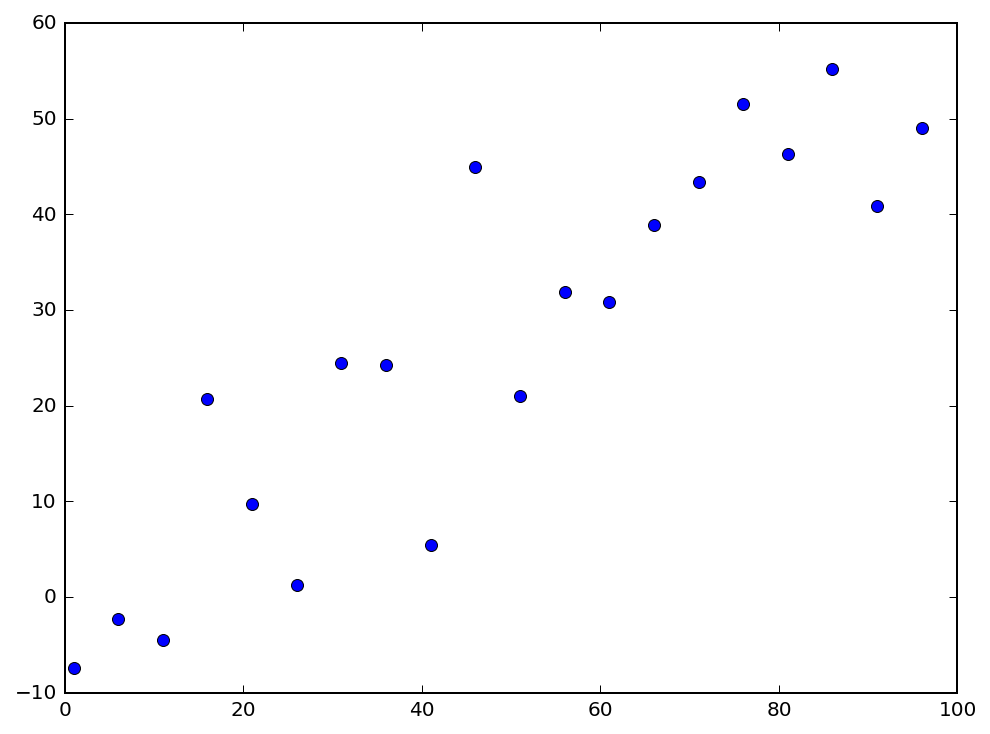

In [13]:
## data simulation
x = np.arange(1, 100, 5)
y = 2.5 + .5 * x + np.random.randn(20) * 10
 
# get number of observations
N = len(x)
 
# plot the data
py.plot(x,y, 'o')
py.show()

# Fitting Bayesian Model

In [14]:
# STAN model (this is the most important part)
regress_code = """
    data {
     int<lower = 0> N; // number of observations
     real y[N]; // response variable
     real x[N]; // predictor variable
    }
    parameters {
     real a; // intercept
     real b; // slope
     real<lower=0> sigma; // standard deviation
    }
    transformed parameters {
     real mu[N]; // fitted values

    for(i in 1:N)
     mu[i] <- a + b*x[i];
    }
    model {
     y ~ normal(mu, sigma);
    }
"""
 
# make a dictionary containing all data to be passed to STAN
regress_dat = {'x': x,
 'y': y,
 'N': N}
 
# Fit the model
fit = pystan.stan(model_code=regress_code, data=regress_dat,
 iter=1000, chains=4)
 
# model summary
print(fit)

Inference for Stan model: anon_model_a480b764fc035d56d0265383b8d86991.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a       -3.12    0.23   4.61  -12.1  -6.08  -3.22  -0.29   6.77    395    1.0
b        0.61  4.1e-3   0.08   0.44   0.55   0.61   0.66   0.77    395    1.0
sigma   10.08    0.12   1.98   7.09   8.64   9.79  11.11  14.76    294   1.01
mu[0]   -2.51    0.23   4.54 -11.34   -5.4   -2.6   0.27   7.25    396    1.0
mu[1]    0.52    0.21   4.19  -7.69  -2.13   0.42   3.07   9.61    400    1.0
mu[2]    3.55    0.19   3.86  -4.06   1.14   3.43   5.87  11.77    407    1.0
mu[3]    6.59    0.17   3.54  -0.36    4.4    6.5   8.72  14.24    416    1.0
mu[4]    9.62    0.16   3.24   3.43   7.58   9.54  11.58  16.54    429    1.0
mu[5]   12.66    0.14   2.97   7.02  10.75  12.61  14.46  18.92    447    1.0
mu[6]   15.69    0.13   2.74  10.

# Diagnostic Plots

''

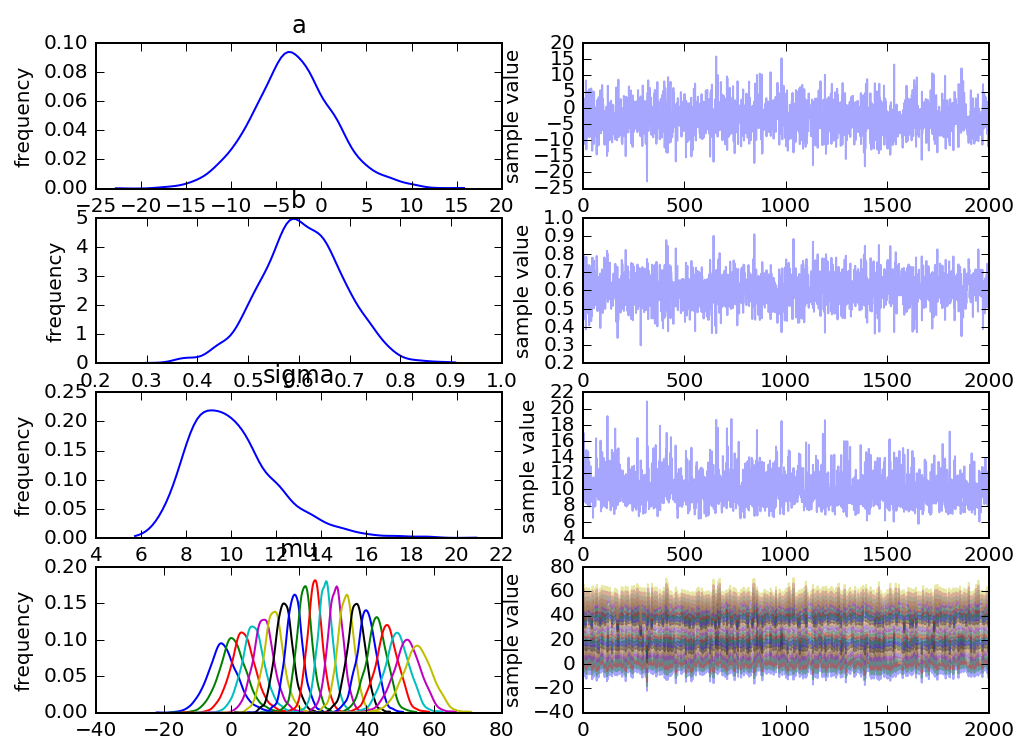

In [33]:
# show a traceplot of ALL parameters. This is a bear if you have many
fit.traceplot()
;

''

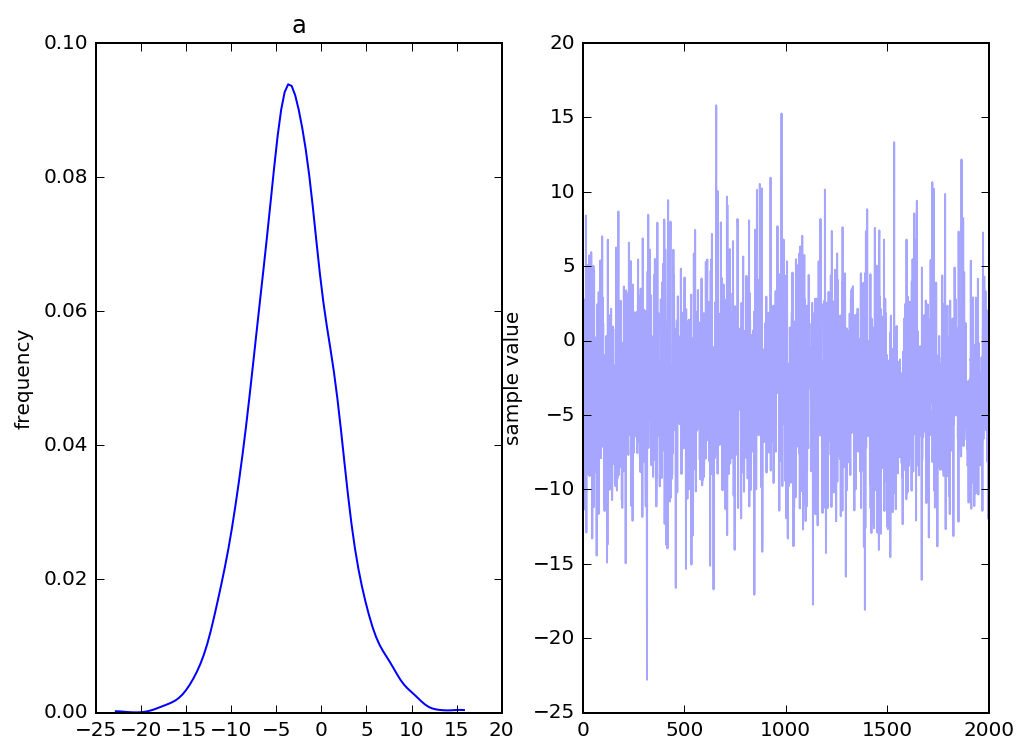

In [34]:
# Instead, show a traceplot for single parameter
fit.plot(['a'])
;

# Prediction

''

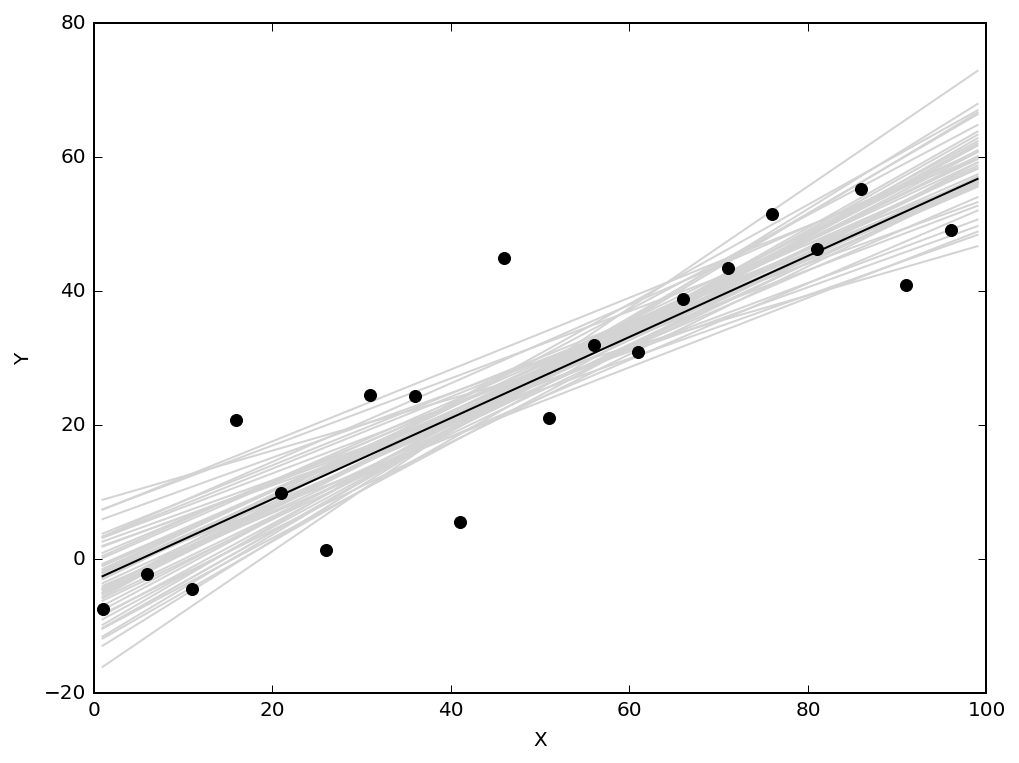

In [30]:
# make a dataframe of parameter estimates for all chains
params = pd.DataFrame(fit.extract(('a','b'), permuted=True))
 
# next, make a prediction function. Making a function makes every step following this 10 times easier
def stanPred(p):
    fitted = p[0] + p[1] * predX
    return pd.Series({'fitted': fitted})
 
# make a prediction vector (the values of X for which you want to predict)
predX = np.arange(1, 100)
 
# get the median parameter estimates
medParam = params.median()
# predict
yhat = stanPred(medParam)
 
# get the predicted values for each chain. This is super convenient in pandas because
# it is possible to have a single column where each element is a list
chainPreds = params.apply(stanPred, axis = 1)
 
## PLOTTING
 
# create a random index for chain sampling
idx = np.random.choice(1999, 50)
# plot each chain. chainPreds.iloc[i, 0] gets predicted values from the ith set of parameter estimates
for i in range(len(idx)):
    py.plot(predX, chainPreds.iloc[idx[i], 0], color='lightgrey')
 
# original data
py.plot(x, y, 'ko')
# fitted values
py.plot(predX, yhat['fitted'], 'k')
 
# supplementals
py.xlabel('X')
py.ylabel('Y')
;